## The salary of jobs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import mutual_info_classif

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Reading data:

In this project, you will develop and critically analyse models for predicting the the salary of jobs. That is, given a job description, gender class it falls under: balanced male-female (0) or maledominated
(1) or female-dominated (2), and the predicted value: salary (mean_salary or salary_bin).

There are two versions of datasets.
- "raw-data": the raw requirements and role in each job id.
- "tfidf_data": (1) removed all stopwords and (2) only retained the 500 words in the full raw job
description data set with highest TFIDF values. As a result, each job ad is now represented as a 500 dimensional feature vector, each dimension corresponding to one of the 500 words.



In [3]:
train_df = pd.read_csv("/Users/macbookpro/Downloads/COMP90049/project/raw-data/train.csv")
train_df.head()

,job_id,requirements_and_role,salary_bin,mean_salary,gender_code
0,JOB-2019-0015706,role purpose role lead finance team asia offic...,9.0,20833.333333,2.0
1,JOB-2019-0013345,lead cim team source procure implement maintai...,9.0,10000.000000,2.0
2,JOB-2019-0011784,responsibilities lecturer contributions go bey...,4.0,4500.000000,2.0
3,JOB-2019-0013898,preparation welcome kits current savings accou...,6.0,6000.000000,2.0
4,JOB-2019-0000435,full time rto 18 months,3.0,3750.000000,2.0


In [4]:
## use the raw data 'test.csv' to submit on kaggle
kaggle_df = pd.read_csv("/Users/macbookpro/Downloads/COMP90049/project/raw-data/test.csv")
kaggle_df.shape

(1738, 3)

In [5]:
# use the raw data 'valid.csv' to test and build evaluation metric
test_df = pd.read_csv("/Users/macbookpro/Downloads/COMP90049/project/raw-data/valid.csv")
test_df.shape

(1737, 5)

In [130]:
tfidf_words = pd.read_csv("/Users/macbookpro/Downloads/COMP90049/project/tfidf-data/tfidf_words.csv",header=None)
tfidf_words.columns = ['Word', 'Index']
tfidf_words.head()

,Word,Index
0,ability,0
1,able,1
2,accordance,2
3,according,3
4,account,4


In [7]:
# training instances
train_tfidf = np.load('/Users/macbookpro/Downloads/COMP90049/project/tfidf-data/train-tfidf.npy')
train_tfidf = pd.DataFrame(train_tfidf)
train_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.0,0.0,0.0,0.0,0.000000,0.258224,0.00000,0.061873,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.027948,0.04098,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,...,0.000000,0.101658,0.087187,0.000000,0.085825,0.00000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.123475,0.054027,0.00000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.201695,0.000000,0.27957,0.000000,0.0,0.0,...,0.081661,0.111852,0.095929,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0


In [8]:
train_tfidf.shape

(13902, 500)

In [9]:
# testing instances for testing on kaggle
kaggle_tfidf = np.load('/Users/macbookpro/Downloads/COMP90049/project/tfidf-data/test-tfidf.npy')
kaggle_tfidf = pd.DataFrame(kaggle_tfidf)
kaggle_tfidf.shape

(1738, 500)

In [10]:
# testing instances for comparing the model and building evaluation metric
test_tfidf = np.load('/Users/macbookpro/Downloads/COMP90049/project/tfidf-data/valid-tfidf.npy')
test_tfidf = pd.DataFrame(test_tfidf)
test_tfidf.shape

(1737, 500)

In [11]:
y_train_bin = train_df['salary_bin'][0:8000]
y_train_bin.shape

(8000,)

In [12]:
y_train_mean = train_df['mean_salary'][0:8000]
y_train_mean.shape

(8000,)

In [13]:
train_tfidf_sup = train_tfidf.iloc[0:8000,]
train_tfidf_sup.shape

(8000, 500)

In [14]:
y_test = test_df['salary_bin']
y_test.shape

(1737,)

## data overview

In [15]:
train_df.iloc[0:8000,]['salary_bin'].unique()

array([9., 4., 6., 3., 1., 0., 2., 8., 7., 5.])

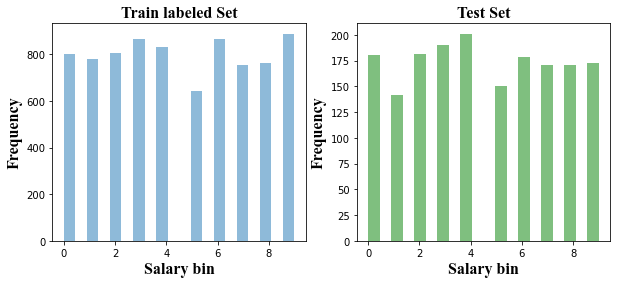

In [16]:
font = {'family': 'Times New Roman', 'size': 16, 'weight':'bold'}
fig, axs = plt.subplots(nrows=1, ncols = 2, figsize=(10,4))

# plot histogram for the train set on the left subplot
axs[0].hist(y_train_bin.values.flatten(),bins=20,alpha=0.5)
axs[0].set_xlabel('Salary bin',fontdict=font)
axs[0].set_ylabel('Frequency',fontdict=font)
axs[0].set_title('Train labeled Set',fontdict=font)
axs[0].tick_params(axis='x', labelsize=10)  # Set font size for x-axis tick labels
axs[0].tick_params(axis='y', labelsize=10)  # Set font size for y-axis tick labels

# plot histogram for the test set on the right subplot
axs[1].hist(y_test.values.flatten(),bins=20,alpha=0.5,color = 'green')
axs[1].set_xlabel('Salary bin',fontdict=font)
axs[1].set_ylabel('Frequency',fontdict=font)
axs[1].set_title('Test Set',fontdict=font)
axs[1].tick_params(axis='x', labelsize=10)  # Set font size for x-axis tick labels
axs[1].tick_params(axis='y', labelsize=10)  # Set font size for y-axis tick labels
fig.set_facecolor('white')  # Specify the desired background color

# Save the plot as an image file
plt.savefig('salary_freq.png',dpi=300)  # Specify the file name and extension

# Show the plot
plt.show()

As seen from above plots, labels in train sets and test sets are balanced.

<AxesSubplot:ylabel='Frequency'>

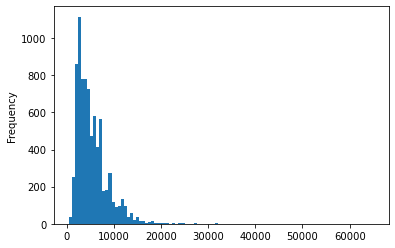

In [17]:
train_df.iloc[0:8000,]['mean_salary'].plot.hist(bins=100)

In [20]:
## features with all 0
train_tfidf_sup[train_tfidf_sup.sum(axis=1) == 0]

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
if (train_tfidf_sup.iloc[303,] == 0).all():
    print('yes')

yes


In [22]:
## the corresponding salary bin
indices = [303,2837,4340,5725,6242,6535,6874,7418]
y_train_bin_0 = [y_train_bin[i] for i in indices]
y_train_bin_0

[9.0, 8.0, 4.0, 1.0, 6.0, 7.0, 1.0, 2.0]

## Feature selection using Mutual Information Score(MI)

Mutual Information measures importance of the feature towards target label. Higher MI score means more important. 

In [23]:
## MI score for all features
mi_score = mutual_info_classif(train_tfidf_sup,y_train_bin)

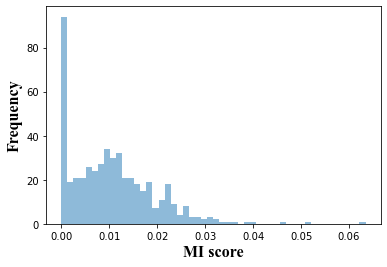

In [24]:
font = {'family': 'Times New Roman', 'size': 16, 'weight':'bold'}

plt.hist(mi_score,bins=50,alpha=0.5)
plt.xlabel('MI score',fontdict=font)
plt.ylabel('Frequency',fontdict=font)
## plt.set_title(,fontdict=font)
plt.tick_params(axis='x', labelsize=10)  # Set font size for x-axis tick labels
plt.tick_params(axis='y', labelsize=10)  # Set font size for y-axis tick labels
# Save the plot as an image file
plt.savefig('MI_features.png',dpi=300, facecolor = 'white')  # Specify the file name and extension

# Show the plot
plt.show()

Check how many features having MI score greater than 0.002

In [243]:
k = len(mi_score[mi_score>0.002])
k

395

Print out the words with high MI score

In [244]:
## include, includes, including, make, making, needed, needs, non, work, working, 
## use, using, related, relevant
MI = SelectKBest(score_func=mutual_info_classif, k=k)
X_train_MI = MI.fit_transform(train_tfidf_sup,y_train_bin)
features_MI = []
for feat_num in MI.get_support(indices=True):
    features_MI.append(tfidf_words['Word'][feat_num])
features_MI

['ability',
 'able',
 'accordance',
 'accounting',
 'accounts',
 'accurate',
 'achieve',
 'actions',
 'actively',
 'activities',
 'ad',
 'administration',
 'administrative',
 'agency',
 'analysis',
 'analytics',
 'analyze',
 'annual',
 'apac',
 'applications',
 'apply',
 'approach',
 'appropriate',
 'architecture',
 'area',
 'areas',
 'asia',
 'aspects',
 'assessment',
 'assigned',
 'assist',
 'assistant',
 'attend',
 'audit',
 'bank',
 'banking',
 'based',
 'basis',
 'benefits',
 'best',
 'brand',
 'build',
 'building',
 'business',
 'candidate',
 'candidates',
 'capabilities',
 'care',
 'career',
 'change',
 'changes',
 'check',
 'claims',
 'class',
 'client',
 'clients',
 'closely',
 'cloud',
 'code',
 'collaborate',
 'collaboration',
 'commercial',
 'communication',
 'communications',
 'companies',
 'company',
 'complete',
 'complex',
 'compliance',
 'computer',
 'consultants',
 'contact',
 'continuous',
 'contractors',
 'contracts',
 'control',
 'controls',
 'coordinate',
 'core',

In [ ]:
# Extracting features from train data 
train_fea_tfidf = train_tfidf_sup[MI.get_support(indices=True)]
test_fea_tfidf = test_tfidf[MI.get_support(indices=True)]
test_fea_tfidf.shape

In [221]:
train_XY_fea = pd.concat([train_fea_tfidf,y_train_bin], axis = 1)
## number of selected features in each class
num_features = []
for i in range(10):
    num_features.append(len(train_XY_fea.columns[:-1][train_XY_fea[train_XY_fea['salary_bin']==i].iloc[:,:-1].sum(axis=0) != 0].to_list()))
num_features   

[362, 362, 362, 362, 362, 362, 362, 362, 362, 362]

## Supervised machine learning

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import warnings

### Logistic regression

Tune parameters

In [30]:
### tuning parameter using 
warnings.simplefilter(action='ignore', category=UserWarning)

# Define the parameter grid to search over
param_grid = {'max_iter': [100, 500, 1000, 5000, 10000]}

# Create a logistic regression classifier
lgr = LogisticRegression()

# Use GridSearchCV to find the best max_iter value
grid_search = GridSearchCV(lgr, param_grid, cv=3)
grid_search.fit(train_fea_tfidf,y_train_bin)

# Print the best parameters and accuracy score
print("Best max_iter value:", grid_search.best_params_['max_iter'])
print("Accuracy:", grid_search.score(test_fea_tfidf,y_test))

Best max_iter value: 100
Accuracy: 0.22337363270005758


### Baseline: Gaussian Naive Bayes

Reason: starting with the assumption of selected features are conditionally indepent and normal distribution given the class, which will give the most possible probablity of predicted class. Such assumptions may be helpful to explain the true behavior in the dataset when using KNN and logistic regression, where assumptions are removed.


In [31]:
### Gaussian naive bayes
GNB = GaussianNB() 
GNB.fit(train_fea_tfidf,y_train_bin)
y_test_pred = GNB.predict(test_fea_tfidf)
acc = accuracy_score(y_test,y_test_pred)
GNB_report = classification_report(y_test,y_test_pred,zero_division=0,output_dict = True)
GNB_report = pd.DataFrame(GNB_report).transpose()[['precision','recall']].round(2)

### Logistic regression
lgr.fit(train_fea_tfidf,y_train_bin)
LR_pred = lgr.predict(test_fea_tfidf)
LR_report = classification_report(y_test.values,LR_pred,zero_division = 0, output_dict=True)
LR_eval = pd.DataFrame(LR_report).transpose()[['precision','recall']].round(2)

pd.concat([GNB_report,LR_eval],axis = 1, keys = ['GNB (baseline)','LR'])

GNB (baseline)               LR       
                  precision recall precision recall
0                      0.34   0.66      0.37   0.52
1                      0.19   0.25      0.15   0.17
2                      0.18   0.15      0.22   0.20
3                      0.13   0.07      0.20   0.18
4                      0.17   0.08      0.16   0.14
5                      0.11   0.07      0.09   0.03
6                      0.18   0.12      0.17   0.20
7                      0.15   0.16      0.14   0.12
8                      0.17   0.13      0.18   0.11
9                      0.25   0.45      0.31   0.52
accuracy               0.21   0.21      0.22   0.22
macro avg              0.19   0.21      0.20   0.22
weighted avg           0.19   0.21      0.20   0.22

## Semi-supverised learning
Definition: Giving unlabeled data a predicted label using trained ML algorithms under supervised learning.

Purpose: Gaining more labeled data to improve the accuracy of ML algorithms 

In [35]:
unlabeled = train_tfidf.iloc[8000::,MI.get_support(indices=True)]
original_index = train_tfidf.index
unlabeled.index = original_index[unlabeled.index]

## unlabeled data with GNB
pred_prob_GNB = GNB.predict_proba(unlabeled)
pred_prob_GNB = pd.DataFrame(pred_prob_GNB)
pred_unlabel = GNB.predict(unlabeled)
all_y_gnb = np.concatenate((y_train_bin,pred_unlabel))

## unlabeled data with lgr
pred_prob_lgr = lgr.predict_proba(unlabeled)
pred_prob_lgr = pd.DataFrame(pred_prob_lgr)
pred_unlabel_lgr = lgr.predict(unlabeled)
all_y_lgr = np.concatenate((y_train_bin,pred_unlabel_lgr))

<function matplotlib.pyplot.show(close=None, block=None)>

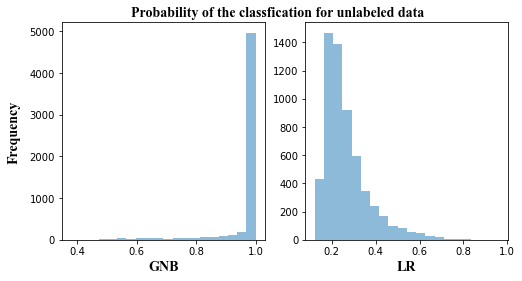

In [59]:
font = {'family': 'Times New Roman', 'size': 14, 'weight':'bold'}
fig, axs = plt.subplots(nrows=1, ncols = 2, figsize=(8,4))
axs[0].hist(pred_prob_GNB.max(axis=1),alpha=0.5,bins = 20)
axs[0].set_xlabel('GNB',fontdict = font)
axs[1].hist(pred_prob_lgr.max(axis=1),alpha=0.5,bins = 20)
axs[1].set_xlabel('LR',fontdict=font)
fig.text(0.5,0.9, 'Probability of the classfication for unlabeled data',ha='center',fontdict=font)
fig.text(0.03,0.5,'Frequency', va='center',rotation = 'vertical',fontdict=font)

plt.savefig('confidence of probability.png',dpi=400, facecolor = 'white')
plt.show


In [57]:
## adjust threshold for logistic regression
p = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
print("logistic regression")
for i in p:
    unconf_ins_LGR = pred_prob_lgr[pred_prob_lgr.max(axis=1)<i]
    unconf_index_LGR = unlabeled.iloc[unconf_ins_LGR.index,:].index
    confi_X_LGR = train_tfidf.drop(unconf_index_LGR)
    confi_X_LGR = confi_X_LGR[MI.get_support(indices=True)]
    confi_y_LGR = np.delete(all_y_lgr,unconf_index_LGR,axis=0)
    lgr_semi = LogisticRegression()
    lgr_semi.fit(confi_X_LGR,confi_y_LGR)
    LR_pred = lgr_semi.predict(test_fea_tfidf)
    acc = accuracy_score(y_test,LR_pred)
    print("threshold",i,"accuracy: ", acc)

logistic regression
threshold 0.0 accuracy:  0.21991940126655152
threshold 0.1 accuracy:  0.21991940126655152
threshold 0.2 accuracy:  0.2274035693724813
threshold 0.3 accuracy:  0.22337363270005758
threshold 0.4 accuracy:  0.2181922855497985
threshold 0.5 accuracy:  0.22452504317789293
threshold 0.6 accuracy:  0.22394933793897526
threshold 0.7 accuracy:  0.22337363270005758
threshold 0.8 accuracy:  0.22394933793897526


In [63]:
## adjust threshold for gaussain naive bayes
p = [0.0,0.99]
print("GNB")
for i in p:
    unconf_ins = pred_prob_GNB[pred_prob_GNB.max(axis=1)<i]
    unconf_index = unlabeled.iloc[unconf_ins.index,:].index
    confi_X_GNB = train_tfidf.drop(unconf_index)
    confi_X_GNB = confi_X_GNB[MI.get_support(indices=True)]
    confi_y_GNB = np.delete(all_y_gnb,unconf_index,axis=0)
    GNB_semi = GaussianNB()
    GNB_semi.fit(confi_X_GNB,confi_y_GNB)
    GNB_pred = GNB_semi.predict(test_fea_tfidf)
    acc = accuracy_score(y_test,GNB_pred)
    print("threshold",i,"accuracy: ", acc)

GNB
threshold 0.0 accuracy:  0.20840529648819806
threshold 0.99 accuracy:  0.2118595279217041


In [55]:
len(pred_prob_lgr[pred_prob_lgr.max(axis=1)>0.0])

5902

## Results

In [64]:
## GNB
## filter the unconfident instances' index
unconf_ins_GNB = pred_prob_GNB[pred_prob_GNB.max(axis=1)<0.99]
unconf_index = unlabeled.iloc[unconf_ins_GNB.index,:].index
## remove the unconfident instances
confi_X = train_tfidf.drop(unconf_index)
confi_X = confi_X[MI.get_support(indices=True)]
confi_y = np.delete(all_y_gnb,unconf_index,axis=0)

## training GNB using semi-supervised learning
GNB_semi = GaussianNB() 
GNB_semi.fit(confi_X,confi_y)
y_test_pred = GNB_semi.predict(test_fea_tfidf)
acc = accuracy_score(y_test,y_test_pred)
GNB_semi_report = classification_report(y_test,y_test_pred,zero_division=0,output_dict = True)
GNB_semi_report = pd.DataFrame(GNB_semi_report).transpose()[['precision','recall']].round(2)

## LR
unconf_ins_LGR = pred_prob_lgr[pred_prob_lgr.max(axis=1)<0.2]
unconf_index_LGR = unlabeled.iloc[unconf_ins_LGR.index,:].index
confi_X_LGR = train_tfidf.drop(unconf_index_LGR)
confi_X_LGR = confi_X_LGR[MI.get_support(indices=True)]
confi_y_LGR = np.delete(all_y_lgr,unconf_index_LGR,axis=0)
### training Logistic regression using semi-supervised learning
lgr_semi = LogisticRegression()
lgr_semi.fit(confi_X_LGR,confi_y_LGR)
LR_pred = lgr_semi.predict(test_fea_tfidf)
LR_semi_report = classification_report(y_test.values,LR_pred,zero_division = 0, output_dict=True)
LR_semi_eval = pd.DataFrame(LR_semi_report).transpose()[['precision','recall']].round(2)
pd.concat([GNB_report, LR_eval, GNB_semi_report,LR_semi_eval],axis = 1, keys = ['GNB (baseline)','LR','GNB after semi','LR after semi'])


GNB (baseline)               LR        GNB after semi         \
                  precision recall precision recall      precision recall   
0                      0.34   0.66      0.37   0.52           0.33   0.64   
1                      0.19   0.25      0.15   0.17           0.18   0.25   
2                      0.18   0.15      0.22   0.20           0.16   0.13   
3                      0.13   0.07      0.20   0.18           0.15   0.07   
4                      0.17   0.08      0.16   0.14           0.17   0.08   
5                      0.11   0.07      0.09   0.03           0.10   0.05   
6                      0.18   0.12      0.17   0.20           0.16   0.10   
7                      0.15   0.16      0.14   0.12           0.19   0.27   
8                      0.17   0.13      0.18   0.11           0.14   0.09   
9                      0.25   0.45      0.31   0.52           0.24   0.45   
accuracy               0.21   0.21      0.22   0.22           0.21   0.21   
macro avg              0.19   0.21      0.20   0.22           0.18   0.21   
weighted avg           0.19   0.21      0.20   0.22           0.18   0.21   

             LR after semi         
                 precision recall  
0                     0.37   0.61  
1                     0.14   0.15  
2                     0.19   0.15  
3                     0.22   0.18  
4                     0.17   0.14  
5                     0.11   0.02  
6                     0.17   0.20  
7                     0.13   0.11  
8                     0.21   0.11  
9                     0.29   0.55  
accuracy              0.23   0.23  
macro avg             0.20   0.22  
weighted avg          0.20   0.23

Comparing the weights of features before and after semi-supervised learning, to see whether the model get improved.

In [210]:
weights = pd.DataFrame(lgr_semi.coef_)
# weight.columns[MI.get_support(indices=True)]
weights.columns = list(MI.get_support(indices=True).tolist())
weights = weights.T
weights['feature'] = weights.index
weights = pd.concat([weights,tfidf_words.iloc[MI.get_support(indices=True),:]['Word']],axis=1)
weights = weights.rename_axis('Coefficients')
weights

,0,1,2,3,4,5,6,7,8,9,feature,Word
Coefficients,,,,,,,,,,,,
0,-0.764095,0.270385,-0.238271,-0.724016,-0.707914,0.729057,0.705696,-0.740372,1.196087,0.273443,0,ability
1,-0.097258,1.224407,0.169399,-0.236564,0.245534,-0.218029,0.728640,0.312788,-0.703323,-1.425593,1,able
2,-0.157859,0.699314,1.488120,-1.008260,-0.823325,-0.316005,1.178172,-0.396154,-0.348781,-0.315220,2,accordance
4,-0.371610,-0.421979,-0.407517,0.019117,0.042103,0.370312,-0.184176,0.413502,-0.058320,0.598570,4,account
5,0.345419,1.305796,-0.323629,-1.125194,-0.828009,1.202059,0.059890,-0.018167,-0.310489,-0.307678,5,accounting
...,...,...,...,...,...,...,...,...,...,...,...,...
493,-0.129764,0.162196,0.734573,0.006475,0.727169,0.057853,0.307326,-0.644309,-0.389436,-0.832083,493,web
494,1.329866,0.336027,0.115483,-0.225262,0.090525,-0.132739,-1.068114,1.759284,-0.683704,-1.521367,494,work
495,0.918141,-1.335505,-0.131652,-0.514175,0.410601,-0.317781,0.278888,0.252155,0.022552,0.416776,495,working


In [242]:
len(list(MI.get_support(indices=True)))

362

In [246]:
orin_weights = pd.DataFrame(lgr.coef_)
# weight.columns[MI.get_support(indices=True)]
orin_weights.columns = list(MI.get_support(indices=True))
orin_weights = orin_weights.T
orin_weights['feature'] = orin_weights.index
orin_weights = pd.concat([orin_weights,tfidf_words.iloc[MI.get_support(indices=True),:]['Word']],axis=1)
orin_weights = orin_weights.rename_axis('Coefficients')
orin_weights

,0,1,2,3,4,5,6,7,8,9,feature,Word
Coefficients,,,,,,,,,,,,
0,-0.510860,0.036898,-0.378027,-0.575157,-0.452391,0.526190,0.438206,-0.105363,0.555121,0.465382,0,ability
1,-0.010033,0.648731,0.332211,0.022684,0.190616,-0.192874,0.258653,0.220777,-0.506552,-0.964213,1,able
2,0.003054,0.684636,0.734327,-0.671239,-0.452266,-0.116014,0.466764,-0.311471,-0.114755,-0.223035,2,accordance
5,-0.159975,-0.397158,-0.469714,-0.017323,-0.065207,0.442108,-0.164599,0.562542,0.007288,0.262038,5,accounting
6,0.467394,0.715851,0.006559,-0.571409,-0.726885,0.746492,0.031078,0.147910,-0.149477,-0.667513,6,accounts
...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.049599,0.227573,0.515327,0.118189,0.440057,0.119998,0.179371,-0.472702,-0.348514,-0.729701,495,working
496,0.841768,0.419432,0.142877,-0.109331,0.195433,0.043171,-0.667538,0.961244,-0.609601,-1.217454,496,works
497,0.491720,-0.888916,-0.040882,-0.388975,0.353871,-0.153769,0.372843,0.036717,0.029478,0.187913,497,world


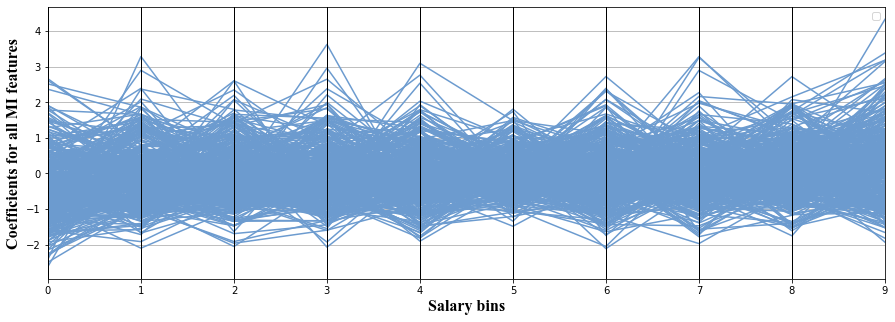

In [234]:
## Semi logistic regression
font = {'family': 'Times New Roman', 'size': 16, 'weight':'bold'}

# Plot parallel coordinate plot
plt.figure(figsize=(15, 5))
pd.plotting.parallel_coordinates(weights.iloc[::,0:11],'feature',color = '#6C9BCF')

plt.legend([])

plt.xlabel("Salary bins",fontdict = font)
plt.ylabel("Coefficients for all MI features",fontdict = font)
plt.savefig('LR coefficients',dpi=400,facefolor='white')

In [254]:
weight[weight[0]>2]['Word']

15     administrative
37             assist
143            duties
207            handle
Name: Word, dtype: object

In [235]:
weight[weight[9]>2]['Word']

,0,Word
33,-0.624646,asia
52,-1.645337,business
74,-0.551436,commercial
82,-0.753091,complex
83,0.020933,compliance
87,-1.200905,consultants
140,-0.120212,drive
177,-0.389626,expertise
196,-1.394270,global
242,-0.781982,investment


In [215]:
train_df[train_df['salary_bin']==9]['mean_salary'].mean()

12511.883202099742

In [252]:
orin_weights[orin_weights[0]>1.5]['Word']

Coefficients
14     administration
36           assigned
141            driven
200        government
Name: Word, dtype: object

In [255]:
orin_weights[orin_weights[9]>2]['Word']

Coefficients
51      building
248         join
250    knowledge
455      systems
456       talent
Name: Word, dtype: object

In [74]:
import csv
kaggle_fea = kaggle_tfidf[MI.get_support(indices=True)]
pred_kaggle = lgr_semi.predict(kaggle_fea)
pred_kaggle = pd.DataFrame(pred_kaggle)
pred_kaggle.to_csv('pred_kaggle.csv')

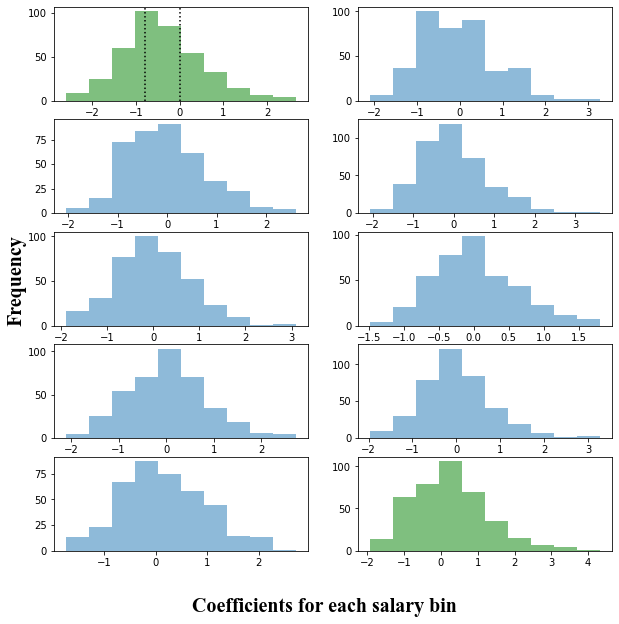

In [237]:
font = {'family': 'Times New Roman', 'size': 20, 'weight':'bold'}
fig, axs = plt.subplots(nrows=5, ncols = 2, figsize=(10,10))
axs[0,0].hist(weights[0],alpha = 0.5,color='green')
axs[0,0].axvline(x=-0.8, linestyle='dotted', color='black')
axs[0,0].axvline(x = 0, linestyle='dotted', color='black')
axs[0,1].hist(weights[1],alpha = 0.5)
axs[1,0].hist(weights[2],alpha = 0.5)
axs[1,1].hist(weights[3],alpha = 0.5)
axs[2,0].hist(weights[4],alpha = 0.5)
axs[2,1].hist(weights[5],alpha = 0.5)
axs[3,0].hist(weights[6],alpha = 0.5)
axs[3,1].hist(weights[7],alpha = 0.5)
axs[4,0].hist(weights[8],alpha = 0.5)
axs[4,1].hist(weights[9],alpha=0.5,color = 'green')
fig.text(0.06,0.5,'Frequency', va='center',rotation = 'vertical',fontdict=font)
fig.text(0.5,0.04, 'Coefficients for each salary bin',ha='center',fontdict=font)
plt.savefig('Coefficients_features.png',dpi=300, facecolor = 'white')  # Specify the file name and extension
plt.show()